In [152]:
import numpy as np
import pandas as pd
from math import cos as cos
import math
import os
import uncertainties
from uncertainties import ufloat
from astropy.time import Time
import matplotlib.pyplot as plt

datapath = '/home/m206265/lalapps_work/J0058-7218/data/'
imgpath = '/home/m206265/lalapps_work/J0058-7218/images/'
resultpath = '/home/m206265/lalapps_work/J0058-7218/result/'

object_name = 'J0058-7218'

In [3]:
def Get_f_band(nu):
    f_min = (1.39-0.195*nu**2/nu_kep**2)*nu
    f_max = 1.57*nu
    return( f_min, f_max )

def Get_fdot_band(nu_dot):
    fdot_min = (1.39-0.585*nu_dot**2/nu_kep**2)*np.abs(nu_dot)
    fdot_max = 1.57*nu_dot
    return( fdot_min, fdot_max )

def Get_fddot_band(nu_ddot):
    fddot_min = (1.39-0.585*nu_ddot**2/nu_kep**2)*(1-2/7)*np.abs(nu_ddot)
    fddot_max = 1.57*nu_ddot
    return( fddot_min, fddot_max )

In [381]:
def getObject(object_name, datapath):
    objectData = pd.read_csv(datapath + 'objects_data.csv', delimiter=',')
    alpha = objectData[objectData.object == object_name]['right ascension']
    delta = objectData[objectData.object == object_name]['declination']
    F0 = objectData[objectData.object == object_name]['F0']
    F1 = objectData[objectData.object == object_name]['F1']
    F2 = objectData[objectData.object == object_name]['F2']
    epoch = objectData[objectData.object == object_name]['epoch']
    
    F0err = objectData[objectData.object == object_name]['F0err'].values
    F1err = objectData[objectData.object == object_name]['F1err'].values
    F2err = objectData[objectData.object == object_name]['F0err'].values

    alpha = to_radian(alpha.values)
    delta = to_radian(delta.values)
    F0 = F0.values
    F1 = F1.values
    F2 = F2.values
    epoch = epoch.values
    
    objectData = np.array([alpha, delta, F0, F1, F2, epoch, F0err, F1err, F2err], dtype = float)
    return (objectData)

def to_radian(degrees):
    result = degrees * math.pi / 180
    return(result)

def TaylorExpansion_old(f, fdot, fddot, ref_time, epoch):
    return(f+fdot*(ref_time-epoch)+fddot*(ref_time-epoch)**2/2) # break into steps, calculate fdot and only then calculate f

In [322]:
objectData = getObject(object_name, datapath)
nu_kep = 506

nu = objectData[2] #frequency of rotation
nudot = objectData[3]
nuddot = objectData[4]

f_min, f_max = Get_f_band(nu)
f_band = f_max - f_min

fdot_min, fdot_max = Get_fdot_band(nudot)
fdot_band = fdot_max - fdot_min

fddot_min, fddot_max = Get_fddot_band(nuddot)
fddot_band = fddot_max - fddot_min

print('f band: ', f_min, f_max, 'delta f:', f_band)
print('f dot band: ', fdot_min, fdot_max, 'delta fdot:', fdot_band)
print('f ddot band: ', fddot_min, fddot_max, 'delta fddot:', fddot_band)


f band:  [63.78335903 63.786895  ] [72.12648182 72.13048959] delta f: [8.34312279 8.34359459]
f dot band:  [8.663036e-11 8.479000e-11] [-9.784868e-11 -9.577000e-11] delta fdot: [-1.8447904e-10 -1.8056000e-10]
f ddot band:  [4.17e-21      nan] [6.594e-21       nan] delta fddot: [2.424e-21       nan]


In [323]:
# braking index
#n = nu1*nu1ddot/nu1dot**2

# epoch = 58924
n = np.array([3, 5, 7]) # magnetic dipole, quadrupole gw, r-mode braking indexes
nu1dot = nudot[1]
nu1 = nu[1]

nu1ddot = n*nu1dot**2/nu1 # calculate 2nd derivative from expected braking index

nu1_err = objectData[6][1]
nu1dot_err = objectData[7][1]

eps_nu1 = nu1_err/nu1 # fractional uncertainty = err/measurement
eps_nu1dot = nu1dot_err/nu1dot

eps_nu1ddot = np.sqrt(4*eps_nu1dot**2+eps_nu1**2) # fractional uncertainty f = x^m*y^m, eps(f) = sqrt(m^2*x+n^2*y)
nu1ddot_err = eps_nu1ddot*nu1ddot
nu1ddot_w_err = np.array([ufloat(nu1ddot[0], nu1ddot_err[0]), 
                          ufloat(nu1ddot[1], nu1ddot_err[1]), 
                          ufloat(nu1ddot[2], nu1ddot_err[2])])

#nu1ddot_w_err = {"n=3" : f"{nu1ddot[0]} +- {nu1ddot_err[0]}", 
               #"n=5" : f"{nu1ddot[1]} +- {nu1ddot_err[1]}",
               #"n=7" : f"{nu1ddot[2]} +- {nu1ddot_err[2]}"}
        
print(nu1ddot_w_err)
print('nu1ddot =',nu1ddot)
print('errors =', nu1ddot_err)

[2.429750595014642e-22+/-4.779837236094383e-23
 4.049584325024404e-22+/-7.96639539349064e-23
 5.669418055034165e-22+/-1.1152953550886894e-22]
nu1ddot = [2.42975060e-22 4.04958433e-22 5.66941806e-22]
errors = [4.77983724e-23 7.96639539e-23 1.11529536e-22]


In [324]:
nu1 = ufloat(nu[1], objectData[6][1])
nu1dot = ufloat(nudot[1], objectData[7][1])
nu1ddot = n*nu1dot**2/nu1

nu2 = ufloat(nu[0], objectData[6][0])
nu2dot = ufloat(nudot[0], objectData[7][0])
nu2ddot = ufloat(nuddot[0], objectData[8][0])


In [378]:
epoch1 = Time(objectData[5][1], format = 'mjd')
epoch2 = Time(objectData[5][0], format = 'mjd')
reftime = 1170798264

epoch1.format = 'gps'
epoch2.format = 'gps'
nu1_on_epoch2 = TaylorExpansion(nu1, nu1dot, nu1ddot, epoch2.value, epoch1.value)
nu1dot_on_epoch2 = TaylorExpansion(nu1dot, nu1ddot, 0, epoch2.value, epoch1.value)

print(nu1_on_epoch2)
print(nu2)

print(nu1dot_on_epoch2)
print(nu2dot)

nu1_on_reftime = TaylorExpansion(nu1, nu1dot, nu1ddot, reftime, epoch1.value)
nu1dot_on_reftime = TaylorExpansion(nu1dot, nu1ddot, 0, reftime, epoch1.value)

print(nu1_on_reftime)
print(nu1dot_on_reftime)

nu2_on_reftime = TaylorExpansion(nu2, nu2dot, nu2ddot, reftime, epoch2.value)
nu2dot_on_reftime = TaylorExpansion(nu2dot, nu2ddot, 0, reftime, epoch2.value)

print(nu2_on_reftime)
print(nu2dot_on_reftime)

nu2_on_epoch1 = TaylorExpansion(nu2, nu2dot, nu2ddot, epoch1.value, epoch2.value)
nu2dot_on_epoch1 = TaylorExpansion(nu2dot, nu2ddot, 0, epoch1.value, epoch2.value)

print(nu2_on_epoch1.n)
print(nu2dot_on_epoch1.n)

[45.94043633884666+/-0.00025086412611215674
 45.94043648047777+/-0.0002508362642903956
 45.94043662210888+/-0.0002508084024686424]
45.940434278+/-0.000000006
[-6.098983936615179e-11+/-5.998001186783959e-12
 -6.098306561025299e-11+/-5.996668644639932e-12
 -6.097629185435417e-11+/-5.995336102495905e-12]
(-6.2324+/-0.0006)e-11
[45.948938935158615+/-0.0005855501028433434
 45.948939705935025+/-0.0005857017309544167
 45.94894047671144+/-0.0005858533590655083]
[-6.102370312918273e-11+/-6.0046629106589e-12
 -6.103950521530456e-11+/-6.007771517764833e-12
 -6.105530730142639e-11+/-6.010880124870766e-12]
(0+/-6)e+07
-0.0+/-0.8
45.943044190396904
-6.249963392e-11


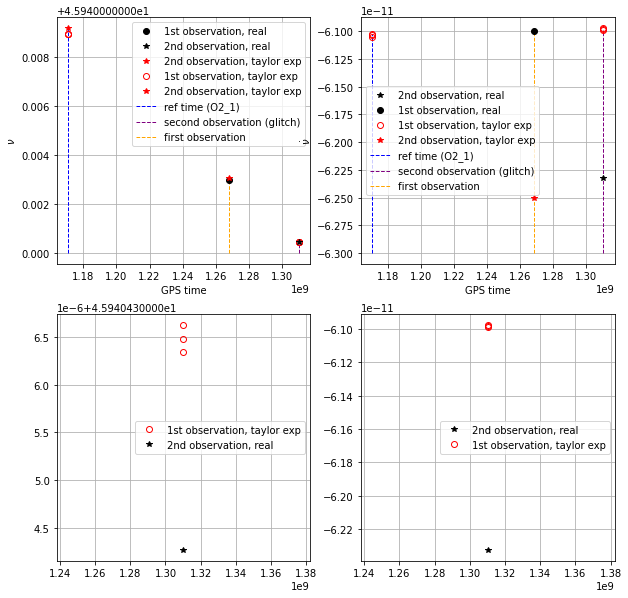

In [380]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (10,10))
ax1.plot(epoch2.value, nu1_on_epoch2[0].n, 'ro', mec = 'red', mfc = 'none')
ax1.plot(epoch2.value, nu1_on_epoch2[1].n, 'ro', mec = 'red', mfc = 'none')
ax1.plot(epoch2.value, nu1_on_epoch2[2].n, 'ro', mec = 'red', mfc = 'none')
ax1.plot(epoch1.value, nu1.n, 'ko', label = '1st observation, real')
ax1.plot(epoch2.value, nu2.n, 'k*', label = '2nd observation, real')
ax1.plot(epoch1.value, nu2_on_epoch1.n, 'r*', label = '2nd observation, taylor exp')

ax1.plot(reftime, nu1_on_reftime[0].n, 'ro', mec = 'red', mfc = 'none')
ax1.plot(reftime, nu1_on_reftime[1].n, 'ro', mec = 'red', mfc = 'none')
ax1.plot(reftime, nu1_on_reftime[2].n, 'ro', mec = 'red', mfc = 'none', label = '1st observation, taylor exp')
ax1.plot(reftime, nu2_on_reftime.n, 'r*', label = '2nd observation, taylor exp')

ax1.vlines(reftime, 45.94, nu2_on_reftime.n, color = 'blue', linestyle = '--', linewidth = 1, label = 'ref time (O2_1)')
ax1.vlines(epoch2.value, 45.94, nu2.n, color = 'purple', linestyle = '--', linewidth = 1, label = 'second observation (glitch)')
ax1.vlines(epoch1.value, 45.94, nu1.n, color = 'orange', linestyle = '--', linewidth = 1,  label = 'first observation')

ax1.grid()
ax1.legend()
ax1.set_xlabel('GPS time')
ax1.set_ylabel(r'$\nu$')
ax1.ticklabel_format(axis='y', style='plain')

ax2.plot(epoch2.value, nu2dot.n, 'k*', label = '2nd observation, real')
ax2.plot(epoch1.value, nu1dot.n, 'ko', label = '1st observation, real')

ax2.plot(epoch2.value, nu1dot_on_epoch2[0].n, 'ro', mec = 'red', mfc = 'none', label = '1st observation, taylor exp')
ax2.plot(epoch2.value, nu1dot_on_epoch2[1].n, 'ro', mec = 'red', mfc = 'none')
ax2.plot(epoch2.value, nu1dot_on_epoch2[2].n, 'ro', mec = 'red', mfc = 'none')
ax2.plot(epoch1.value, nu2dot_on_epoch1.n, 'r*', label = '2nd observation, taylor exp')

ax2.plot(reftime, nu1dot_on_reftime[0].n, 'ro', mec = 'red', mfc = 'none')
ax2.plot(reftime, nu1dot_on_reftime[1].n, 'ro', mec = 'red', mfc = 'none')
ax2.plot(reftime, nu1dot_on_reftime[2].n, 'ro', mec = 'red', mfc = 'none')

ax2.vlines(reftime, -6.3e-11, nu1dot_on_reftime[0].n, color = 'blue', linestyle = '--',linewidth = 1, label = 'ref time (O2_1)')
ax2.vlines(epoch2.value, -6.3e-11, nu1dot_on_epoch2[0].n, color = 'purple', linestyle = '--', linewidth = 1, label = 'second observation (glitch)')
ax2.vlines(epoch1.value, -6.3e-11, nu1dot.n, color = 'orange', linestyle = '--', linewidth = 1, label = 'first observation')

ax2.grid()
ax2.legend()
ax2.set_xlabel('GPS time')
ax2.set_ylabel(r'$\dot{\nu}$')

ax3.plot(epoch2.value, nu1_on_epoch2[0].n, 'ro', mec = 'red', mfc = 'none', label = '1st observation, taylor exp')
ax3.plot(epoch2.value, nu1_on_epoch2[1].n, 'ro', mec = 'red', mfc = 'none')
ax3.plot(epoch2.value, nu1_on_epoch2[2].n, 'ro', mec = 'red', mfc = 'none')
ax3.plot(epoch2.value, nu2.n, 'k*', label = '2nd observation, real')
ax3.grid()
ax3.legend()

ax4.plot(epoch2.value, nu2dot.n, 'k*', label = '2nd observation, real')
ax4.plot(epoch2.value, nu1dot_on_epoch2[0].n, 'ro', mec = 'red', mfc = 'none', label = '1st observation, taylor exp')
ax4.plot(epoch2.value, nu1dot_on_epoch2[1].n, 'ro', mec = 'red', mfc = 'none')
ax4.plot(epoch2.value, nu1dot_on_epoch2[2].n, 'ro', mec = 'red', mfc = 'none')
ax4.grid()
ax4.legend()

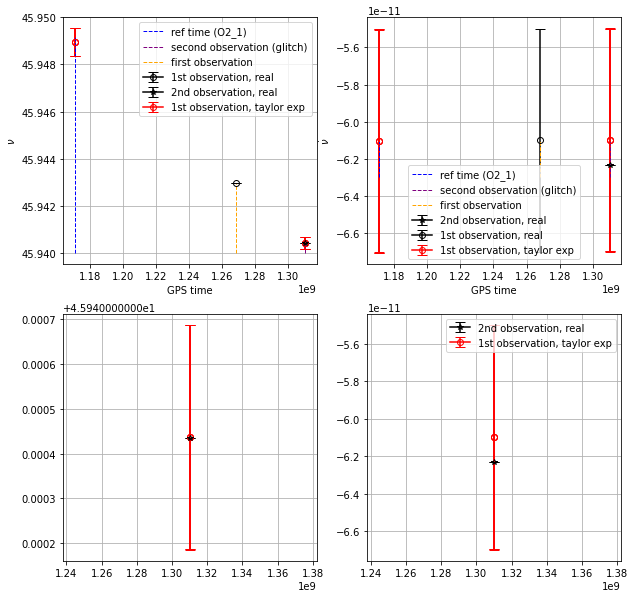

In [372]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (10,10))

ax1.errorbar(epoch2.value, nu1_on_epoch2[0].n, yerr = nu1_on_epoch2[0].s,
             color = 'red', marker = 'o', mec = 'red', mfc = 'none',
            capsize = 5, ecolor = 'r')
ax1.errorbar(epoch2.value, nu1_on_epoch2[1].n, yerr = nu1_on_epoch2[1].s,
             color = 'red', marker = 'o', mec = 'red', mfc = 'none',
            capsize = 5, ecolor = 'r')
ax1.errorbar(epoch2.value, nu1_on_epoch2[2].n, yerr = nu1_on_epoch2[2].s,
            color = 'red', marker = 'o', mec = 'red', mfc = 'none',
            capsize = 5, ecolor = 'r')
ax1.errorbar(epoch1.value, nu1.n, yerr = nu1.s,
            color = 'k', marker = 'o', mec = 'k', mfc = 'none',
            capsize = 5, ecolor = 'k', label = '1st observation, real')
ax1.errorbar(epoch2.value, nu2.n, yerr= nu2.s, 
            color = 'k', marker = '*', mec = 'k', mfc = 'none',
            capsize = 5, ecolor = 'k', label = '2nd observation, real')

ax1.errorbar(reftime, nu1_on_reftime[0].n, yerr = nu1_on_reftime[0].s,
            color = 'red', marker = 'o', mec = 'red', mfc = 'none',
            capsize = 5, ecolor = 'r')
ax1.errorbar(reftime, nu1_on_reftime[1].n, yerr = nu1_on_reftime[1].s,
            color = 'red', marker = 'o', mec = 'red', mfc = 'none',
            capsize = 5, ecolor = 'r')
ax1.errorbar(reftime, nu1_on_reftime[2].n, yerr = nu1_on_reftime[2].s,
            color = 'red', marker = 'o', mec = 'red', mfc = 'none',
            capsize = 5, ecolor = 'r', label = '1st observation, taylor exp')
#ax1.errorbar(reftime, nu2_on_reftime.n, yerr = nu2_on_reftime.s,
        #    color = 'red', marker = 'o', mec = 'red', mfc = 'none',
          #  capsize = 5, ecolor = 'r', label = '2nd observation, taylor exp')
ax1.vlines(reftime, 45.94, nu2_on_reftime.n, color = 'blue', linestyle = '--', linewidth = 1, label = 'ref time (O2_1)')
ax1.vlines(epoch2.value, 45.94, nu2.n, color = 'purple', linestyle = '--', linewidth = 1, label = 'second observation (glitch)')
ax1.vlines(epoch1.value, 45.94, nu1.n, color = 'orange', linestyle = '--', linewidth = 1,  label = 'first observation')

ax1.grid()
ax1.legend()
ax1.set_xlabel('GPS time')
ax1.set_ylabel(r'$\nu$')
#ax1.ticklabel_format(axis='y', style='plain')

ax2.errorbar(epoch2.value, nu2dot.n,  yerr= nu2dot.s, 
            color = 'k', marker = '*', mec = 'k', mfc = 'none',
            capsize = 5, ecolor = 'k', label = '2nd observation, real')
ax2.errorbar(epoch1.value, nu1dot.n, yerr = nu1dot.s,
            color = 'k', marker = 'o', mec = 'k', mfc = 'none',
            capsize = 5, ecolor = 'k', label = '1st observation, real')

ax2.errorbar(epoch2.value, nu1dot_on_epoch2[0].n, yerr = nu1dot_on_epoch2[0].s,
            color = 'red', marker = 'o', mec = 'red', mfc = 'none',
            capsize = 5, ecolor = 'r', label = '1st observation, taylor exp')
ax2.errorbar(epoch2.value, nu1dot_on_epoch2[1].n, yerr = nu1dot_on_epoch2[1].s,
            color = 'red', marker = 'o', mec = 'red', mfc = 'none',
            capsize = 5, ecolor = 'r')
ax2.errorbar(epoch2.value, nu1dot_on_epoch2[2].n, yerr = nu1dot_on_epoch2[2].s,
            color = 'red', marker = 'o', mec = 'red', mfc = 'none',
            capsize = 5, ecolor = 'r')

ax2.errorbar(reftime, nu1dot_on_reftime[0].n,yerr = nu1dot_on_reftime[0].s,
            color = 'red', marker = 'o', mec = 'red', mfc = 'none',
            capsize = 5, ecolor = 'r')
ax2.errorbar(reftime, nu1dot_on_reftime[1].n,yerr = nu1dot_on_reftime[1].s,
            color = 'red', marker = 'o', mec = 'red', mfc = 'none',
            capsize = 5, ecolor = 'r')
ax2.errorbar(reftime, nu1dot_on_reftime[2].n,yerr = nu1dot_on_reftime[2].s,
            color = 'red', marker = 'o', mec = 'red', mfc = 'none',
            capsize = 5, ecolor = 'r')

ax2.vlines(reftime, -6.3e-11, nu1dot_on_reftime[0].n, color = 'blue', linestyle = '--',linewidth = 1, label = 'ref time (O2_1)')
ax2.vlines(epoch2.value, -6.3e-11, nu1dot_on_epoch2[0].n, color = 'purple', linestyle = '--', linewidth = 1, label = 'second observation (glitch)')
ax2.vlines(epoch1.value, -6.3e-11, nu1dot.n, color = 'orange', linestyle = '--', linewidth = 1, label = 'first observation')

ax2.grid()
ax2.legend()
ax2.set_xlabel('GPS time')
ax2.set_ylabel(r'$\dot{\nu}$')

ax3.errorbar(epoch2.value, nu1_on_epoch2[0].n, yerr = nu1_on_epoch2[0].s,
             color = 'red', marker = 'o', mec = 'red', mfc = 'none',
            capsize = 5, ecolor = 'r')
ax3.errorbar(epoch2.value, nu1_on_epoch2[1].n, yerr = nu1_on_epoch2[1].s,
             color = 'red', marker = 'o', mec = 'red', mfc = 'none',
            capsize = 5, ecolor = 'r')
ax3.errorbar(epoch2.value, nu1_on_epoch2[2].n, yerr = nu1_on_epoch2[2].s,
            color = 'red', marker = 'o', mec = 'red', mfc = 'none',
            capsize = 5, ecolor = 'r')
ax3.errorbar(epoch2.value, nu2.n, yerr= nu2.s, 
            color = 'k', marker = '*', mec = 'k', mfc = 'none',
            capsize = 5, ecolor = 'k', label = '2nd observation, real')
ax3.grid()

ax4.errorbar(epoch2.value, nu2dot.n,  yerr= nu2dot.s, 
            color = 'k', marker = '*', mec = 'k', mfc = 'none',
            capsize = 5, ecolor = 'k', label = '2nd observation, real')

ax4.errorbar(epoch2.value, nu1dot_on_epoch2[0].n, yerr = nu1dot_on_epoch2[0].s,
            color = 'red', marker = 'o', mec = 'red', mfc = 'none',
            capsize = 5, ecolor = 'r', label = '1st observation, taylor exp')
ax4.errorbar(epoch2.value, nu1dot_on_epoch2[1].n, yerr = nu1dot_on_epoch2[1].s,
            color = 'red', marker = 'o', mec = 'red', mfc = 'none',
            capsize = 5, ecolor = 'r')
ax4.errorbar(epoch2.value, nu1dot_on_epoch2[2].n, yerr = nu1dot_on_epoch2[2].s,
            color = 'red', marker = 'o', mec = 'red', mfc = 'none',
            capsize = 5, ecolor = 'r')
ax4.grid()
ax4.legend()